# Retrieval Augmented Generation (RAG) CHATBOT with BBC News




**Retrieval Augmented Generation, or RAG** for short, is a technique used to improve the accuracy and reliability of large language models (LLMs) like me. Here's the basic idea:

Imagine LLMs as judges: They have some general understanding of the world based on their training data, but sometimes they need specific expertise for complex cases. Just like judges consult law libraries, RAG allows LLMs to access external knowledge sources for factual grounding.

How it works:

1. **Retrieval**: When you ask me a question, RAG first uses an information retrieval component to find relevant information from an external knowledge base. This could be a website, a document library, or even a custom database.

2. **Augmentation**: Then, it combines the information retrieved with your original question and feeds it to the LLM.

3. **Generation**: The LLM, now armed with both its internal knowledge and the retrieved facts, generates a response that's more likely to be accurate and reliable.



Benefits of RAG:

- **Factual consistency**: LLMs can be prone to making up facts or relying on outdated information. RAG ensures answers are based on current, reliable sources.

- **Transparency**: RAG often provides links to the sources used, allowing you to verify the information yourself.

- **Adaptability**: RAG can be applied to various LLMs and knowledge bases, making it a versatile tool.


Limitations of RAG:

- **Data quality**: The quality of RAG outputs depends on the quality of the knowledge base used.

- **Computational cost**: Adding an information retrieval step can increase the computational cost of generating responses.

#### Install & Import Necessary Libraries

In [1]:
# !pip install chromadb
# %pip install --upgrade --quiet  langchain-google-genai

In [1]:
import os
import time
import sys
import pandas as pd
import numpy as np


# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.probability import FreqDist
# from nltk.tokenize import word_tokenize, sent_tokenize

import google.generativeai as genai
import langchain_google_genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAI


from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import (
    SystemMessage,
    HumanMessage,
    AIMessage
)

from chromadb.errors import InvalidDimensionException

from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import RetrievalQA, ConversationalRetrievalChain


sys.path.append('../')
from helper.SummarizationMetrics import SummarizationMetrics
from helper.chatgpt_automation import ChatGPTAutomation, split_text_into_chunks
from helper.bard_automation import BardAutomation, split_text_into_chunks


c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load Dataset

In [5]:
df = pd.read_excel("../Data/newsbbc_train.xlsx")

df.head()


,File_path,Articles,Summaries,transcript,summary
0,business,Cuba winds back economic clock..Fidel Castro's...,Fidel Castro's decision to ban all cash transa...,Cuba winds back economic clock..Fidel Castro's...,Fidel Castro's decision to ban all cash transa...
1,politics,Blair looks to election campaign..Tony Blair's...,There was little in terms of concrete proposal...,Blair looks to election campaign..Tony Blair's...,There was little in terms of concrete proposal...
2,entertainment,New York rockers top talent poll..New York ele...,New York electro-rock group The Bravery have c...,New York rockers top talent poll..New York ele...,New York electro-rock group The Bravery have c...
3,politics,Terror suspects face house arrest..UK citizens...,British citizens are being included in the cha...,Terror suspects face house arrest..UK citizens...,British citizens are being included in the cha...
4,politics,'No more concessions' on terror..Charles Clark...,"On Monday, MPs voted 272-219 in favour of the ...",'No more concessions' on terror..Charles Clark...,"On Monday, MPs voted 272-219 in favour of the ..."


In [6]:
bbc_train_df = df.groupby('File_path').head(5)
bbc_train_df['File_path'].value_counts()

File_path
business         5
politics         5
entertainment    5
sport            5
tech             5
Name: count, dtype: int64

In [7]:
bbc_train_df.shape

(25, 5)

##### Get API KEY

In [8]:
from os import environ

from dotenv import load_dotenv

load_dotenv(".env", override=True)
openai_api_key = environ.get("OPENAI_API_KEY")
gcp_api_key = environ.get("GCP_API_KEY")

In [9]:
# Test embedding Model
# from langchain_google_genai import GoogleGenerativeAIEmbeddings
# embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=gcp_api_key)
# vector = embeddings.embed_query("hello, world!")
# vector[:5]

##### Define OpenAI Models

In [10]:
openai_models = {
    "models": [
        "gpt-3.5-turbo-0125",
        # "gpt-3.5-turbo-1106",
        # "gpt-4",
        # "gpt-4-1106-preview"
    ],
    "max_tokens": [
        16385,
        # 16385,
        # 8192,
        # 128000,

    ]
}

df_openai_models = pd.DataFrame(openai_models)
df_openai_models

,models,max_tokens
0,gpt-3.5-turbo-0125,16385


In [11]:
df_scores = pd.DataFrame(columns=['model', 'method', 'max_tokens', 'topic' ,'num_tokens' ,'transcript', 'original summary' ,'summary', 'grammar', 'readability', 'rouge', 'bert_score', 'time_taken', 'prompt', 'temperature'])
df_scores

# df_scores.to_excel("closed_source_model_rag_comparison.xlsx", index=False)

# df_scores = pd.read_excel("./result/closed_source_model_rag_topic_comparison.xlsx")
# df_scores.shape

,model,method,max_tokens,topic,num_tokens,transcript,original summary,summary,grammar,readability,rouge,bert_score,time_taken,prompt,temperature


In [12]:
for model_index, model_row in df_openai_models.iterrows():
    model_name = model_row["models"]
    print(model_name)

    temperature = 0

    llm = ChatOpenAI(model=model_name,openai_api_key=openai_api_key, temperature=temperature)
    
    # prompt_template = "Write a concise summary of the following: {text}"""

    # PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])

    for index, row in bbc_train_df.iterrows():
        
        # Clear temp vector memory.
        Chroma().delete_collection()
        
        method = "RAG"

        # get the summary
        start_time = time.time()
        num_tokens = llm.get_num_tokens(row['transcript'])
        print("Number of tokens:", num_tokens)

        max_tokens = model_row["max_tokens"]

        source_knowledge = row['transcript']
        print(source_knowledge)
        query = "Write a concise summary"
        
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([source_knowledge])

        embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
        try:
            vector = Chroma.from_documents(documents=docs, embedding=embeddings)
        except InvalidDimensionException:
            # Clear data in Chroma DB to avoid dimension matching error
            Chroma().delete_collection()
            vector = Chroma.from_documents(documents=docs, embedding=embeddings)                 
        vector.persist()
        retriever = vector.as_retriever(search_kwargs={'k': len(docs)})

        qa_chain = ConversationalRetrievalChain.from_llm(
        llm = llm,
        retriever=retriever,
        return_source_documents=True,
        )
        
        chat_history = []
        result = qa_chain({'question': query, 'chat_history': chat_history})
        summary = result['answer']
        print(summary)

        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'topic': row['File_path'],
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index(),
            'num_tokens': num_tokens,
            'prompt': query,
            'temperature': temperature
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)
        time.sleep(1)

gpt-3.5-turbo-0125


Number of tokens: 762
Cuba winds back economic clock..Fidel Castro's decision to ban all cash transactions in US dollars in Cuba has once more turned the spotlight on Cuba's ailing economy...All conversions between the US dollar and Cuba's "convertible" peso will from 8 November be subject to a 10% tax. Cuban citizens, who receive money from overseas, and foreign visitors, who change dollars in Cuba, will be affected. Critics of the measure argue that it is a step backwards, reflecting the Cuban president's desire to increase his control of the economy and to clamp down on private enterprise. In a live television broadcast announcing the measure, President Castro's chief aide said it was necessary because of the United States' increasing "economic aggression". "The ten percent obligation applies exclusively to the dollar by virtue of the situation created by the new measures of the US government to suffocate our country," he said...The Bush administration has taken an increasingly hars

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 498.49it/s]


done in 1.61 seconds, 0.62 sentences/sec


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_23480\4074984934.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)


Number of tokens: 702
Blair looks to election campaign..Tony Blair's big speech will be looked back on as the performance that kicked off the election campaign...That poll may still be about 16 weeks away, but there can be little doubt left that the campaign is now in full swing. The prime minister used his speech to a selected audience in the south east to set out his broad brush election manifesto. There was a detailed account of the government's past record, with a major emphasis on the economy and public services. There was an attempt to draw the line under the gossip surrounding his rift with Chancellor Gordon Brown. And there was an insistence on the importance of the party continuing to operate as unremittingly "New" Labour - although that may continue to irritate his chancellor...There was little in terms of concrete proposals or what might form manifesto pledges, although the prime minister talked about a "New Labour manifesto that will be aimed at all sections of society". Hi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.98it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.86 seconds, 0.54 sentences/sec
Number of tokens: 718
New York rockers top talent poll..New York electro-rock group The Bravery have come top of the BBC News website's Sound of 2005 poll to find the music scene's most promising new act...The Bravery, who have been compared to The Cure and New Order, were the most heavily-tipped act in the survey of 110 impartial critics and broadcasters. Rock band Keane won Sound of 2004 while US rapper 50 Cent topped Sound of 2003. Other new artists in this year's list include London indie group Bloc Party at second and UK rapper Kano third. The Bravery played their first gig in 2003 and have since supported bands including The Libertines, Interpol and Echo and the Bunnymen...They were the subject of a record company bidding war in 2004 and their debut single, Unconditional, caused a huge buzz when it was released in the UK in November. Singer Sam Endicott said he felt "great" about coming top of the Sound of 2005 list. "Anyone that says they

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


done in 1.33 seconds, 0.75 sentences/sec
Number of tokens: 671
Terror suspects face house arrest..UK citizens suspected of involvement in terrorism could face house arrest as part of a series of new measures outlined by the home secretary...It comes after law lords ruled that the detention of 12 foreign terror suspects without trial breached human rights. Charles Clarke's planned "control orders" mean anyone suspected of being involved in terrorism could be subject to house arrest, curfews or tagging. The Law Society dubbed Mr Clarke's new proposals an "abuse of power". Deals are already being sought to deport some of the foreign detainees who are mainly held in Belmarsh Prison in London under the current laws introduced after the US terror attacks on 11 September 2001. Mr Clarke said efforts would continue to deport them to their countries of origin Algeria, Tunisia, Egypt and Jordan without them facing torture or death...Under the proposed changes - prompted by the House of Lords rul

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 478.75it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.81 seconds, 0.55 sentences/sec
Number of tokens: 642
'No more concessions' on terror..Charles Clarke says he has "no desire" to offer more concessions on his controversial anti-terror plans to get them on to the statute book...MPs voted in favour of the Prevention of Terrorism Bill after Mr Clarke agreed to key changes - but Labour's majority was reduced to 14. The Bill now faces opposition from peers angry at house arrest proposals. Lord Strathclyde, Tory leader in the Lords, said ministers should expect it to be "substantially re-written"...The Bill proposes "control orders", which as well as house arrest could impose curfews, tagging or bans on telephone and internet use. They would replace current powers to detain foreign terror suspects without trial, which the law lords have ruled against...On Monday, MPs voted 272-219 in favour of the Bill after key concessions from Mr Clarke. The government earlier saw its 161-strong majority cut to just 14 as a cross-party amendment 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 332.33it/s]


done in 1.49 seconds, 0.67 sentences/sec
Number of tokens: 634
Howard denies split over ID cards..Michael Howard has denied his shadow cabinet was split over its decision to back controversial Labour plans to introduce ID cards...The Tory leader said his front bench team had reached a "collective view" after holding a "good discussion", but admitted it was "not an easy issue". He had decided to support the plans as the police said they would help fight terror, crime and illegal immigration. The Lib Dems have pledged to oppose the bill when it is debated next Monday...Tory sources say senior party figures had argued vociferously against the ID card scheme. Among those reported to have serious reservations over the strategy were senior shadow cabinet members David Davis, Oliver Letwin and Tim Yeo. But Mr Howard denied Mr Yeo, his transport and environment spokesman, said the plans "stink". He also said he was confident shadow home secretary Mr Davis would "set out the position very clear

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.09it/s]


done in 1.58 seconds, 0.63 sentences/sec
Number of tokens: 726
Chelsea denied by James heroics..A brave defensive display, led by keeper David James, helped Manchester City hold the leaders Chelsea...After a quiet opening, James denied Damien Duff, Jiri Jarosik and Mateja Kezman, while Paul Bosvelt cleared William Gallas' header off the line. Robbie Fowler should have scored for the visitors but sent his header wide. Chelsea had most of the possession in the second half but James kept out Frank Lampard's free-kick and superbly tipped the same player's volley wide. City went into the game with the proud record of being the only domestic team to beat Chelsea this season. And there was little to alarm them in the first 30 minutes as Chelsea - deprived of Arjen Robben and Didier Drogba through injury - struggled to pose much of a threat. Indeed, it was the visitors who looked likelier to enliven a drab opening played at a lethargic pace. Shaun Wright-Phillips - watched by England boss Sven

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.51it/s]


done in 1.95 seconds, 0.51 sentences/sec
Number of tokens: 753
Guantanamo man 'suing government'..A British terror suspect held in Guantanamo Bay for 33 months plans to sue the government, it is reported...Martin Mubanga claimed in the Observer that an MI6 officer played a key role in consigning him to the US camp in Cuba, following his arrest in Zambia. Mr Mubanga, 32, from Wembley, London, said he was brutally interrogated and daubed with urine at the camp. The home secretary said he would not be launching an investigation and that the media reports were not "well informed". Mr Mubanga, who has dual British and Zambian nationality, was one of four Britons who were released from the US camp in January...He said he was sent there after being interrogated by a British man who said he was from MI6, shortly after his arrest in Zambia in March 2002. Mr Mubanga said he had been in Afghanistan and Pakistan to study Islam. But he said he was unable to return to the UK because he had lost his 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.32it/s]


done in 2.03 seconds, 0.49 sentences/sec
Number of tokens: 875
Could Yukos be a blessing in disguise?..Other things being equal, the notion of entrepreneurs languishing in jail while their companies are sold off for a song ought to be bad for business...But in the looking-glass world of modern Russia, the opposite might just be true, a new report* has argued. The study, from the Centre for Economic Policy Research, does not praise the rough handling of oil company Yukos. But it argues that more rigorous tax policing has benefited all Russian firms, even targets of the tax police. "An increase in tax enforcement can increase the amount [of dividends and other income] outside shareholders will receive, even accounting for increased levels of taxation," the authors say...The paper's reasoning is complex, and is based on a sophisticated model of the relationship between tax regimes and corporate governance - in particular, the propensity of management to steal from the company. The calcula

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.10 seconds, 0.48 sentences/sec
Number of tokens: 756
Asian quake hits European shares..Shares in Europe's leading reinsurers and travel firms have fallen as the scale of the damage wrought by tsunamis across south Asia has become apparent...More than 23,000 people have been killed following a massive underwater earthquake and many of the worst hit areas are popular tourist destinations. Reisurance firms such as Swiss Re and Munich Re lost value as investors worried about rebuilding costs. But the disaster has little impact on stock markets in the US and Asia...Currencies including the Thai baht and Indonesian rupiah weakened as analysts warned that economic growth may slow. "It came at the worst possible time," said Hans Goetti, a Singapore-based fund manager. "The impact on the tourist industry is pretty devastating, especially in Thailand." Travel-related shares dropped in Europe, with companies such as Germany's TUI and Lufthansa and France's Club Mediterranne sliding. Ins

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 250.05it/s]


done in 2.38 seconds, 0.42 sentences/sec
Number of tokens: 707
The year search became personal..The odds are that when you fire up your browser, you go straight to your favourite search engine, rather than type in a web address...Some may see this as the height of laziness, but in an era of information overload, search has become a vital tool in navigating the net. It is symptomatic of how the way we use the internet is changing. And as Google has shown, there is money in offering a service that people cannot live without. There is no shortage of companies vying for the loyalty of web searchers, offering a wealth of different services and tools to help you find what you want. Over the past 12 months, giants of the technology world such as Microsoft and Yahoo have sought to grab a slice of the search action. "User experience has contributed to people searching more," said Yonca Brunini of Yahoo. As people become more familiar with the internet, they tend to spend more time online and as

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.54it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.30 seconds, 0.44 sentences/sec
Number of tokens: 842
Doors open at biggest gadget fair..Thousands of technology lovers and industry experts have gathered in Las Vegas for the annual Consumer Electronics Show (CES)...The fair showcases the latest technologies and gadgets that will hit the shops in the next year. About 50,000 new products will be unveiled as the show unfolds. Microsoft chief Bill Gates is to make a pre-show keynote speech on Wednesday when he is expected to announce details of the next generation Xbox...The thrust of this year's show will be on technologies which put people in charge of multimedia content so they can store, listen to, and watch what they want on devices any time, anywhere. About 120,000 people are expected to attend the trade show which stretches over more than 1.5 million square feet. Highlights will include the latest trends in digital imaging, storage technologies, thinner flat screen and high-definition TVs, wireless and portable technologi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 284.17it/s]


done in 2.31 seconds, 0.43 sentences/sec
Number of tokens: 829
File-swappers ready new network..Legal attacks on websites that help people swap pirated films have forced the development of a system that could be harder to shut down...One site behind the success of the BitTorrent file-swapping system is producing its own software that avoids the pitfalls of the earlier program. A test version of the new Exeem program will be released in late January. But doubts remain about the new networks ability to ensure files being swapped are "quality copies"...In late December movie studios launched a legal campaign against websites that helped people swap pirated movies using the BitTorrent network. The legal campaign worked because of the way that BitTorrent is organised. That file-sharing system relies on links called "trackers" that point users to others happy to share the file they are looking for. Shutting down sites that listed trackers crippled the BitTorrent network. One of the sites shu

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 76.92it/s]


done in 3.65 seconds, 0.27 sentences/sec
Number of tokens: 639
Toxic web links help virus spread..Virus writers have begun using the power of the web to spread their malicious wares...A Windows virus called Bofra is turning infected machines into distributors of its malicious code. Those clicking on the poisoned links in e-mail messages sent out by infected machines may fall victim to the virus. The trick is being used to prevent the progam being caught by anti-virus software that combs through code contained in e-mail attachments...The virus that uses this trick is called Bofra and the first member of the family of worms appeared on 10 November. They exploit a Windows vulnerability that was discovered only a few days earlier...Like many other recent viruses, Bofra plunders the address book in Microsoft Outlook for e-mail addresses and scours other files on an infected machine for fresh target addresses. The virus uses its own mail sending software to despatch e-mail messages to potent

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.09it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.29 seconds, 0.44 sentences/sec
Number of tokens: 787
Mobiles 'not media players yet'..Mobiles are not yet ready to be all-singing, all-dancing multimedia devices which will replace portable media players, say two reports...Despite moves to bring music download services to mobiles, people do not want to trade multimedia services with size and battery life, said Jupiter. A separate study by Gartner has also said real-time TV broadcasts to mobiles is "unlikely" in Europe until 2007. Technical issues and standards must be resolved first, said the report. Batteries already have to cope with other services that operators offer, like video playback, video messaging, megapixel cameras and games amongst others. Bringing music download services based on the success of computer-based download services will put more demands on battery life...Fifty percent of Europeans said the size of a mobile was the most important factor when it came to choosing their phone, but more power demands tend

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.50it/s]


done in 1.92 seconds, 0.52 sentences/sec
Number of tokens: 800
European medal chances improve..What have the European Indoor trials told us? Well, I think we could be heading to the European Championships with half a dozen medal prospects...It was good to see athletes beginning to make steps forward, to see a few new faces and there were lots of personal bests kicking around...The best performance on the track for me was Sarah Claxton's win in the 60m hurdles. Running sub-eight seconds twice in a week puts her right up there and if she repeats that in Madrid she will be close to picking up a medal. But what was great about Sunday's performance was that she was under pressure to produce the goods when it counted. Diane Allahgreen has been our best hurdler for some time now and I think she was surprised to be beaten by Sarah. And knowing that she got the better of Diane in a head-to-head race will give Sarah confidence. In the men's race on Saturday, Allan Scott was right in there and th

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 62.50it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.22 seconds, 0.45 sentences/sec
Number of tokens: 838
Disaster claims 'less than $10bn'..Insurers have sought to calm fears that they face huge losses after an earthquake and giant waves killed at least 38,000 people in southern Asia...Munich Re and Swiss Re, the world's two biggest reinsurers, have said exposure will be less than for other disasters. Rebuilding costs are likely to be cheaper than in developed countries, and many of those affected will not have insurance, analysts said. Swiss Re has said total claims are likely to be less than $10bn (£5.17bn). Swiss Re believes that the cost would be substantial but that it is unlikely to be in double-digit billions, the Financial Times reported. Munich Re, the world's largest reinsurance company, said that its exposure is less than 100m euros (£70m; $136m)...At least 10 countries have been affected, with Sri Lanka, Indonesia, India and Thailand among the worst hit. The region's resorts and Western tourists are expected to be 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


done in 2.66 seconds, 0.38 sentences/sec
Number of tokens: 694
Franz Ferdinand's art school lesson..Scottish rock band Franz Ferdinand, who shot to prominence in 2004, have won two Brit Awards...With their self-titled debut, Franz Ferdinand have achieved what most rock bands crave - high credibility and critical acclaim while also selling stacks of CDs. They have risen to the head of the UK's art rock ranks with an album of songs that are catchy, creative and original enough to sound fresh. With a cool, spiky, fun sound previously associated with bands like Talking Heads, they hit upon a style that had been out of fashion for a while and so was ripe for another airing. Their first UK single hit number three last January, followed by two more top 20 hits, while the album has sold more than 600,000 copies in 11 months on release. In September it was named album of the year winning the prestigious Mercury Music Prize...On the festivals circuit, they have been one of the main attractions f

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 200.09it/s]


done in 2.00 seconds, 0.50 sentences/sec
Number of tokens: 712
Man Utd stroll to Cup win..Wayne Rooney made a winning return to Everton as Manchester United cruised into the FA Cup quarter-finals...Rooney received a hostile reception, but goals in each half from Quinton Fortune and Cristiano Ronaldo silenced the jeers at Goodison Park. Fortune headed home after 23 minutes before Ronaldo scored when Nigel Martyn parried Paul Scholes' free-kick. Marcus Bent missed Everton's best chance when Roy Carroll, who was later struck by a missile, saved at his feet...Rooney's return was always going to be a potential flashpoint, and he was involved in an angry exchange with a spectator even before kick-off. And Rooney's every touch was met with a deafening chorus of jeers from the crowd that once idolised the 19-year-old. Everton started brightly and Fortune needed to be alert to scramble away a header from Bent near the goal-line. But that was the cue for United to take complete control with a su

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


done in 2.98 seconds, 0.34 sentences/sec
Number of tokens: 774
Stars shine on Bafta red carpet..Hollywood stars brought a touch of glamour to London on Saturday for the biggest night in the British film calendar...Cate Blanchett, Leonardo DiCaprio and Richard Gere were just some of the actors who attended the 2005 Bafta film awards. They emerged from limos at Leicester Square to an uncertain British climate that threatened rain one moment and promised late winter sunshine the next. But the gods were certainly shining on the thousands of film fans who lined the red carpet to meet their idols. Screaming built up into a crescendo as more and more big name stars appeared. The biggest cheer of the night was reserved for The Aviator star Leonardo DiCaprio, who paused in the chilly February air to sign autographs for the throngs. He said the ear-piercing welcome was "unlike anything I've ever encountered. It's very intense and very loud."..Best actress winner Imelda Staunton, who wore a green

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 99.98it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.20 seconds, 0.45 sentences/sec
Number of tokens: 805
Paris promise raises Welsh hopes..Has there been a better Six Nations match than Saturday's epic in Paris?..And can the Welsh revival continue all the way to a first Grand Slam since 1978? Those are the two questions occupying not just Wales supporters but rugby fans as a whole after a scintillating display in Paris. Welsh legend Mervyn Davies, a member of two of three Grand Slam-winning sides of the 1970s, hailed it as "one of the great performances of the past three decades". Martyn Williams, Wales' two-try scorer on the day, called it "one of the most surreal games I have ever played in". A crestfallen France coach, Bernard Laporte, simply observed: "There was a French half and there was a Welsh half". And what a half it was for the Red Dragonhood, transforming a 15-6 half-time deficit into an 18-15 lead within five mesmerising minutes of the second period. But while that passage of play showed the swelling self-belief o

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 111.08it/s]


done in 2.30 seconds, 0.44 sentences/sec
Number of tokens: 707
Rapper Kanye West's shrewd soul..US hip-hop star Kanye West - who leads the race for this year's Grammys with 10 nominations - rose to prominence by producing songs for artists such as Jay-Z and Alicia Keys...He then emerged from his behind-the-scenes role to become an artist as well as a producer. But his solo career almost ended before it began after a near-fatal car crash left West with his jaw wired shut in 2002. The resulting song, Through the Wire, became West's first UK hit in April 2004 and subsequent album The College Dropout became a transatlantic success, both critically and commercially. West, 26, began rapping as a teenager at his Chicago school, inspired by the beats and rhymes of 1980s pioneers Run DMC...Hip-hop producer No ID encouraged West to sample old soul and R&B hits then revive them with an updated sound, an approach that would become his trademark. "I feel like a lot of the soul that's in those old r

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 76.93it/s]


done in 2.75 seconds, 0.36 sentences/sec
Number of tokens: 636
Redford's vision of Sundance..Despite sporting a corduroy cap pulled low over his face plus a pair of dark glasses, Robert Redford cuts an unmistakable figure through the star-struck crowds at Sundance...It's a rare downtown appearance for the man who started the annual festival in Park City, Utah back in the 1980s. Now in its twenty-first year, Sundance continues to grow. Some 45,000 people are estimated to have descended on this small ski town with nothing but movies on the mind. It's an opportunity to meet and make deals. Redford wanted Sundance to be a platform for independent film-makers, but the commercial success of many showcased films have led to criticism that the festival is becoming too mainstream...Smaller festivals like Slamdance and XDance, which take place during the same week in Park City, are competing for Sundance's limelight. But Redford is not worried. "The more the merrier," he says. "The point was to 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 496.66it/s]


done in 1.77 seconds, 0.56 sentences/sec
Number of tokens: 697
Water firm Suez in Argentina row..A conflict between the Argentine State and water firm Aguas Argentinas, controlled by France's Suez, is casting doubt on the firm's future...The firm, which serves the province of Buenos Aires, wants a tariff rise of 60% to fund water-supply improvements. The government has rejected the 60% rise and wants Aguas Argentinas to make an annual investment of 400m pesos ($136m; £72.3m) in improvements. Planning Minister Julio De Vido has offered State help but not for "free"...Mr De Vido said that the Argentine state would not make a contribution "in the form of a subsidy"...He has said a contribution could be made in return for a seat on the company's board. He added that the government is in discussions with Aguas Argentinas about what role it might take in the event that a State contribution is agreed. However, Aguas Argentinas told the Argentine newspaper Clarin it would not accept any change

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


done in 2.71 seconds, 0.37 sentences/sec
Number of tokens: 594
Lions blow to World Cup winners..British and Irish Lions coach Clive Woodward says he is unlikely to select any players not involved in next year's RBS Six Nations Championship...World Cup winners Lawrence Dallaglio, Neil Back and Martin Johnson had all been thought to be in the frame for next summer's tour to New Zealand. "I don't think you can ever say never," said Woodward. "But I would have to have a compulsive reason to pick any player who is not available to international rugby." Dallaglio, Back and Johnson have all retired from international rugby over the last 12 months but continue to star for their club sides. But Woodward added: "The key thing that I want to stress is that I intend to use the Six Nations and the players who are available to international rugby as the key benchmark. "My job, along with all the other senior representatives, is to make sure that we pick the strongest possible team. "If you are not p

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 90.92it/s]


done in 1.82 seconds, 0.55 sentences/sec


In [14]:
print(df_scores.shape)
df_scores.head(3)


(25, 16)


,model,method,max_tokens,topic,num_tokens,transcript,original summary,summary,grammar,readability,rouge,bert_score,time_taken,prompt,temperature,bleu
0,gpt-3.5-turbo-0125,RAG,16385,business,762,Cuba winds back economic clock..Fidel Castro's...,Fidel Castro's decision to ban all cash transa...,Cuba has implemented a 10% tax on US dollar co...,[],100 words required.,"[{'rouge-1': {'r': 0.16326530612244897, 'p': 0...","([tensor(0.9078)], [tensor(0.8389)], [tensor(0...",4.644140,Write a concise summary,0,6.624872e-03
1,gpt-3.5-turbo-0125,RAG,16385,politics,702,Blair looks to election campaign..Tony Blair's...,There was little in terms of concrete proposal...,Tony Blair's recent speech marked the beginnin...,"[Offset 90, length 6, Rule ID: MORFOLOGIK_RULE...",100 words required.,"[{'rouge-1': {'r': 0.1317365269461078, 'p': 0....","([tensor(0.8738)], [tensor(0.8153)], [tensor(0...",2.485966,Write a concise summary,0,1.361237e-79
2,gpt-3.5-turbo-0125,RAG,16385,entertainment,718,New York rockers top talent poll..New York ele...,New York electro-rock group The Bravery have c...,"The Bravery, a New York electro-rock group, to...","[Offset 24, length 12, Rule ID: MORFOLOGIK_RUL...",100 words required.,"[{'rouge-1': {'r': 0.2962962962962963, 'p': 0....","([tensor(0.9142)], [tensor(0.8610)], [tensor(0...",2.949865,Write a concise summary,0,6.577025e-02


In [15]:
df_scores.to_excel("./result/closed_source_model_rag_topic_comparison.xlsx", index=False)

In [7]:
df_scores = pd.read_excel("./result/closed_source_model_rag_topic_comparison.xlsx")
print(df_scores.shape)
df_scores.head(0)

(50, 16)


,model,method,max_tokens,topic,num_tokens,transcript,original summary,summary,grammar,readability,rouge,bert_score,time_taken,prompt,temperature,bleu


In [9]:
gcp_models = {
    # Models selected
    "models": [
        "gemini-pro",
        # "chat-bison-001",
        # "text-bison-001"
    ],

    # Input Token
    "max_tokens": [
        30720,
        # 4096,
        # 8196,
    ]
}


df_gcp_models = pd.DataFrame(gcp_models)
df_gcp_models

,models,max_tokens
0,gemini-pro,30720


In [39]:
# llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=gcp_api_key, temperature=0, convert_system_message_to_human=True)
# llm.get_num_tokens("hi")

1

No Error: Return no information found in provided documents.

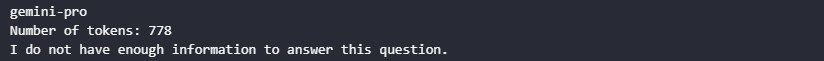

In [15]:
for model_index, model_row in df_gcp_models.iterrows():
    model_name = model_row["models"]
    print(model_name)

    temperature = 0

    # if "chat" in model_name.lower():
    #   llm = ChatVertexAI(temperature=temperature, model=model_name, verbose=True)
    # else:
    #   llm = VertexAI(temperature=temperature, model=model_name, verbose=True)
    
    llm = ChatGoogleGenerativeAI(model=model_name, google_api_key=gcp_api_key, temperature=temperature, convert_system_message_to_human=True)
    # Test first row
    for index, row in bbc_train_df.head(1).iterrows():
        method = "RAG"

        # get the summary
        start_time = time.time()
        num_tokens = llm.get_num_tokens(row['transcript'])
        print("Number of tokens:", num_tokens)

        max_tokens = model_row["max_tokens"]
        query = "Write a concise summary"
        
#         augmented_prompt = f"""Using the contexts below, answer the query.

# Contexts:
# {source_knowledge}

# Query: {query}"""
        
        # prompt = HumanMessage(
        #     content=augmented_prompt
        # )
        

        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row['transcript']])
        # print("Number of chunks:", len(docs))
        embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=gcp_api_key)
        # vector = Chroma.from_documents(docs, embedding=embeddings)


        try:
            vector = Chroma.from_documents(documents=docs, embedding=embeddings)
        except InvalidDimensionException:
            Chroma().delete_collection()
            vector = Chroma.from_documents(documents=docs, embedding=embeddings)      

        vector.persist()
        retriever = vector.as_retriever(search_kwargs={'k': len(docs)})


        qa_chain = ConversationalRetrievalChain.from_llm(

        llm = llm,
        retriever=retriever,
        return_source_documents=True,
        )
        
        chat_history = []
        result = qa_chain({'question': query, 'chat_history': chat_history})
        summary = result['answer']
        print(summary)

        # # break
        # summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce', token_max=max_tokens , map_prompt=PROMPT)
        # summary = summary_chain.run(docs)

        

        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'topic': row['File_path'],
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index(),
            'num_tokens': num_tokens,
            'prompt': query,
            'temperature': temperature
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)
        time.sleep(1)

gemini-pro
Number of tokens: 778
I do not have enough information to answer this question.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\

done in 1.89 seconds, 0.53 sentences/sec


In [ ]:
df_scores.to_excel("./result/closed_source_model_rag_topic_comparison.xlsx", index=False)